# Evaluation

In [2]:
import json
import torch
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from dinov2.models.vision_transformer import DinoVisionTransformer, vit_large
from dinov2.models.vision_transformer import vit_base
from torchvision.transforms import ToTensor,ToPILImage

/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [16]:
def extract_max_knn_performance(file_path):
    max_accuracy = None
    with open(file_path, "r") as file:
        for line in file:
            data = json.loads(line)
            for value in data.values():
                if max_accuracy is None or value > max_accuracy:
                    max_accuracy = value
    return max_accuracy if max_accuracy is not None else None

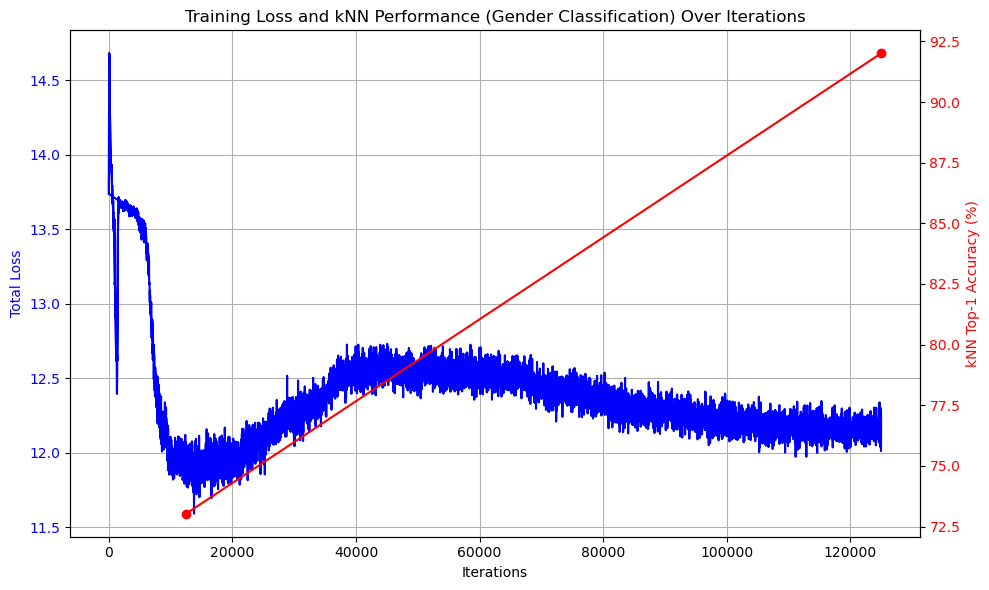

In [18]:
metrics_file = "./CelebA_gt/training_metrics.json"
knn_files = {
    12499: "./CelebA_gt/eval/training_12499/knn_gender_with_original_val_dataset/results_eval_knn.json",
    124999: "./CelebA_gt/eval/training_124999/knn_gender_with_original_val_dataset/results_eval_knn.json",
}
knn_points = {
    checkpoint: extract_max_knn_performance(path)
    for checkpoint, path in knn_files.items()
}

with open(metrics_file, "r") as file:
    metrics = [json.loads(line) for line in file]

iterations = [entry["iteration"] for entry in metrics]
total_loss = [entry["total_loss"] for entry in metrics]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(iterations, total_loss, label="Total Loss", color="blue")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Total Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

ax2 = ax1.twinx()
checkpoints = list(knn_points.keys())
knn_accuracies = list(knn_points.values())
ax2.plot(checkpoints, knn_accuracies, label="kNN Top-1 Accuracy", color="red", marker="o", linestyle="-")
ax2.set_ylabel("kNN Top-1 Accuracy (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Training Loss and kNN Performance (Gender Classification) Over Iterations")
fig.tight_layout()

plt.show()

**Comment:** Loss curve is similar to: https://github.com/facebookresearch/dinov2/issues/143#issuecomment-1651732518
TODO: Perform knn- and linear evaluation for each teacher checkpoint and plot the results. Then compare it with image retrieval performance.

## Loading Customly Pre-Trained DINOv2 Model

In [2]:
# !pip install omegaconf

In [5]:
from dinov2.utils.config import get_cfg_from_args
from dinov2.utils.utils import load_pretrained_weights
from dinov2.models import build_model, build_model_from_cfg
from dinov2.data import make_dataset, make_data_loader, DatasetWithEnumeratedTargets, SamplerType
from dinov2.eval.utils import ModelWithNormalize, extract_features_with_dataloader

In [6]:
class Args:
    def __init__(self, config_file, output_dir=None, opts=None):
        self.config_file = config_file
        self.output_dir = output_dir or ""
        self.opts = opts or []

In [8]:
args = Args(config_file="./CelebA_gt/config.yaml")
cfg = get_cfg_from_args(args)
model, _ = build_model_from_cfg(cfg, only_teacher=True)
pretrained_weights = './CelebA_gt/eval/training_124999/teacher_checkpoint.pth'
load_pretrained_weights(model, pretrained_weights, "teacher")
model.eval()
model = ModelWithNormalize(model)

## Create Embeddings

In [7]:
from dinov2.data.transforms import make_classification_eval_transform

In [8]:
# Change these two according to the model loaded above and used dataset below:
MODEL_NAME = "CelebA_gt"
INPUT_DATASET = "CelebA_Original"
# Don't change:
EMBEDDING_NAME = f"{MODEL_NAME}_{INPUT_DATASET}_emb"

In [9]:
# Calculated in ./data/datasets/celeba.ipynb
CELEB_A_ORIGINAL_TRAIN_MEAN = (0.50641638, 0.42589831, 0.38323391)
CELEB_A_ORIGINAL_TRAIN_STD = (0.31044251, 0.29029403, 0.28966635)

In [15]:
transform = make_classification_eval_transform(mean=CELEB_A_ORIGINAL_TRAIN_MEAN, std=CELEB_A_ORIGINAL_TRAIN_STD)
dataset = make_dataset(dataset_str="CelebAOriginalVal", transform=transform)
dataset = DatasetWithEnumeratedTargets(dataset)

Load image list


In [17]:
batch_size = 12 # cf. yaml train configs.
num_workers = 5 # cf. knn eval.
shuffle = False
sampler_type = SamplerType.EPOCH

data_loader = make_data_loader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, sampler_type=sampler_type)
features, all_labels = extract_features_with_dataloader(model=model, data_loader=data_loader, sample_count=len(dataset))

/home/stud/m/mc085/mounted_home/dinov2_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [11]:
dataset = CelebAOriginalVal()
example_img, _ = dataset[0]

Load image list


In [12]:
with torch.no_grad():
    input_tensor = transform(example_img).unsqueeze(0)
    embedding = model.forward(input_tensor)
    embedding /= embedding.norm(dim=-1, keepdim=True)

In [16]:
embedding.cpu().numpy()[0]

array([-0.00440669, -0.03091217, -0.00522957, ..., -0.01157288,
        0.0032254 , -0.01709352], dtype=float32)

In [20]:
batch_size = 12
results = {}
output_file = f"./embeddings/{EMBEDDING_NAME}.json"

with torch.no_grad():
    batch_images = []
    batch_names = []

    for idx in tqdm(range(12), desc="Processing images"):
        try:
            image, _ = dataset[idx]
            image_path = dataset.paths[idx]
            image_name = Path(image_path).name

            batch_images.append(image)
            batch_names.append(image_name)

            if len(batch_images) == batch_size or idx == len(dataset) - 1:
                preprocessed_images = torch.stack([transform(image) for image in batch_images])
                embeddings = model.forward(preprocessed_images)
                embeddings /= embeddings.norm(dim=-1, keepdim=True)

                for name, embedding in zip(batch_names, embeddings):
                    results[name] = embedding.cpu().numpy().tolist()

                batch_images = []
                batch_names = []

        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            continue

with open(output_file, "w") as f:
    json.dump(results, f)

print(f"Embeddings created and saved in {output_file}.")

Processing images: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]

Embeddings created and saved in ./embeddings/CelebA_gt_CelebA_Original_emb.json.


In [19]:
assert torch.cuda.is_available(), "CUDA is not available. Ensure that the code is running on a GPU."

AssertionError: CUDA is not available. Ensure that the code is running on a GPU.

In [3]:
torch.cuda.is_available()

False